## Blending galaxies
This code was designed to plot 10 realizations of SED, the measured fluxes and the high resolution emission of the accretion disk at 5100 angstrom for some galaxies.

In [1]:
import sys,os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from collections import Counter
#from scipy.stats import chi2_contingency
#from scipy.stats import chi2
#from scipy.stats import ks_2samp
#import itertools
#from matplotlib import gridspec
#import math
from astropy import units as u
import astropy.constants as const
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.266)

In [2]:
Torus_models = ['NK0','SKIRTOR_1P', 'S04']
colors = ['red', 'blue', 'green', 'purple']   
Galaxies = []
for i in os.listdir(Torus_models[0]):
    Galaxies.append(i)

In [3]:
def properties_dict(Torus_models, Galaxies):
    n_data = len(Galaxies)
    k = 0 
    column_names = ['SFR_IR', 'logMstar', 'Tdust', 'LIR(8-1000)', 'Ltor(1-30)', 'LAGN(0.1-30)', 'AGNfrac(8-1000)',\
                    '-ln_like', 'TO_par','Torus_model', 'z', 'Name'] 
    
    Prop_table = pd.DataFrame(columns = column_names)
    for i in Torus_models:
        model_dist = []
        for j in Galaxies:
            data = pd.read_csv(i + '/'+ j + '/posteriors_'+j+'.txt', delim_whitespace=True, decimal=".", skiprows = 0)
            cnames = data.columns.tolist()[1:]
            data = pd.read_csv(i + '/'+ j + '/posteriors_'+j+'.txt', delim_whitespace=True, decimal=".",\
                                   names = cnames, skiprows = 1)
            SEDs = pd.read_csv('brown_test/brown2018_41.txt', delim_whitespace=True, decimal=".", skiprows = 0)
            redshift = SEDs[SEDs['#IDName'] == j]['z']
            
            if i == 'NK0' or i == 'SKIRTOR_1P' or i == 'SKIRTOR_Cigale':
                to_par = data['incl']
            else:
                to_par = data['Nh']

            sub_table= data[column_names[:-4]]
            new_columns = column_names[-4:]
            new_data = [[to_par[k], i, redshift.values[0], j] for k in range(100)]
            add = pd.DataFrame(data = new_data,columns = new_columns)
            sub_table = pd.concat([sub_table,add], axis=1)
            tables = [Prop_table, sub_table]
            Prop_table = pd.concat([d.set_index(column_names) for d in tables], axis=1).reset_index()
    return Prop_table

In [4]:
table = properties_dict(Torus_models, Galaxies)
table

,SFR_IR,logMstar,Tdust,LIR(8-1000),Ltor(1-30),LAGN(0.1-30),AGNfrac(8-1000),-ln_like,TO_par,Torus_model,z,Name
0,0.0000,2.8569,32.5594,38.6061,44.8422,45.1781,1.0000,-1774.3365,21.6276,S04,0.034397,Mrk509
1,0.0000,3.5453,33.1077,38.0073,41.4246,43.6616,0.9996,-1879.3477,21.6497,S04,0.034397,Mrk509
2,0.0000,4.6892,20.2850,37.4123,43.0253,43.0278,1.0000,-157.6326,50.9569,NK0,0.003859,NGC3227Central
3,0.0000,4.7382,37.7082,38.9200,44.0086,44.8541,1.0000,-191.3791,21.5196,S04,0.030021,Mrk421
4,0.0000,5.0050,32.3476,39.0602,44.8856,45.1976,1.0000,-45.3973,21.5017,S04,0.034397,Mrk509
...,...,...,...,...,...,...,...,...,...,...,...,...
12295,1454.7892,12.5953,21.2536,46.5740,46.5732,46.9356,0.3778,-55.2672,3.5737,SKIRTOR_1P,0.296840,H1821+643
12296,1589.5104,11.7668,21.9845,46.6124,46.5179,46.9257,0.3269,-55.4486,15.9067,SKIRTOR_1P,0.296840,H1821+643
12297,1954.6382,12.3062,36.6444,46.7022,46.5298,46.9168,0.2903,-56.8110,13.5681,SKIRTOR_1P,0.296840,H1821+643
12298,1989.5410,12.4006,22.1019,46.7099,46.5454,46.9252,0.2941,-52.7546,21.4001,SKIRTOR_1P,0.296840,H1821+643


In [5]:
def blending(Galaxy, wl_obs, data, ymin, ymax, data_type = 'Lnu', save = 'Yes', rad = 'Yes'):
    z = table[table['Name'] == Galaxy]['z'].unique()[0]      # Redshift
    f_obs = (3*1e8)/(wl_obs*1e-10)                          # Observed frequency [Hz]
    f_rest = f_obs*(1+z)                
    if data_type == 'Fnu':
        D_L = cosmo.luminosity_distance(z).to(u.cm).value       # Relation distance-luminosity
        flux =  wl_obs*data*4*np.pi*(D_L)**2                    # Flux [erg s⁻¹]
    elif data_type == 'Lnu':
        flux = data
    fig = plt.figure(figsize=(14, 6))
    plt.ylabel(r'$\nu L(\nu)$  $[erg \cdot s^{-1}]$', fontsize = 14) 
    plt.xlabel(r'log($\nu$) ', fontsize = 14) 

    for i in range(len(Torus_models)):
        model_dist = []
        data = pd.read_csv(Torus_models[i] + '/'+ Galaxy + '/output_SEDs100_'+Galaxy+'.txt', \
                           delim_whitespace=True, decimal=".", skiprows = 0)
        data = data.astype(float)
        log_f = data.iloc[:, 0]        # Log frequency [Hz]
        SB = data.iloc[:, 10]         # Starburst
        BB = data.iloc[:, 20]        # Blue bump
        GA = data.iloc[:, 30]        # Galaxy
        TO = data.iloc[:, 40]        # Torus
        if rad == 'Yes':
            RAD = data.iloc[:, 50]        # Synchrotron of AGN
            TOTAL = data.iloc[:, 60]     # Total
            BB_dr = data.iloc[:, 70]     # BB dereddened
        else:
            TOTAL = data.iloc[:, 50]     # Total
            BB_dr = data.iloc[:, 60]     # BB dereddened


        # OBSERVED SED
        color = colors[i]
        transp = 0.3
        plt.semilogy(log_f, SB, marker = '', color = colors[i], linestyle = '-', alpha = transp)
        plt.semilogy(log_f, BB, marker = '', color = colors[i], linestyle = '-', alpha = 1)
        plt.semilogy(log_f, GA, marker = '', color = colors[i], linestyle = '-', alpha = transp)
        plt.semilogy(log_f, TO, marker = '', color = colors[i], linestyle = '-', alpha = transp)
        if rad == 'Yes':
            plt.semilogy(log_f, RAD, marker = '', color = colors[i], linestyle = '-', alpha = transp)
        plt.semilogy(log_f, TOTAL, marker = '', color = colors[i], linestyle = '-',label = Torus_models[i])
        plt.semilogy(log_f[log_f < 16.5], BB_dr[log_f < 16.5], marker = '', color = colors[i], \
                     linestyle = '-.', alpha = transp)
    
    plt.semilogy(np.log10(f_rest), flux,color = 'orange', marker = '*', markeredgecolor= 'black', \
                 markersize = 15,  linestyle = '', label =  str(wl_obs) + ' Angstrom', zorder = 9)
    SED_Brown_XR = pd.read_csv("brown_test/brown2018_34_4bands_10err.txt", delim_whitespace=True, decimal=".", skiprows = 0)
    SED_Brown_noXR = pd.read_csv("brown_test/brown2018_test2.txt", delim_whitespace=True, decimal=".", skiprows = 0)

    if (Galaxy in SED_Brown_XR['#IDName'].values):
        dataframe = SED_Brown_XR
        row = SED_Brown_XR.index[SED_Brown_XR['#IDName'] == Galaxy][0]
    else:
        dataframe = SED_Brown_noXR
        row = SED_Brown_noXR.index[SED_Brown_noXR['#IDName'] == Galaxy][0]
        
    flux_u = u.Jy*1e-3    
    wl_u = 1e-6
    freq_obs = (3*1e8)/(np.array(dataframe.iloc[row, 2::3])*wl_u)                    # Observed frequency [Hz]
    Fnu_Jy = np.array(dataframe.iloc[row, 3::3])*flux_u                              # Spectral flux density [Jy]
    Fnu_cgs = np.array([i.to(u.erg/u.s/(u.cm)**2 /u.Hz).value for i in Fnu_Jy])    # Intensity [erg s⁻¹ cm⁻² Hz⁻¹]
    D_L = cosmo.luminosity_distance(z).to(u.cm).value                              # Relation distance-luminosity
    fluxes =  freq_obs*Fnu_cgs*4*np.pi*(D_L)**2                                      # Flux [erg s⁻¹]
        
    # Uncertainty [erg s⁻¹]
    error = freq_obs*np.array([(i*flux_u).to(u.erg/u.s/(u.cm)**2 /u.Hz).value*4*np.pi*(D_L)**2 for i in dataframe.iloc[row, 4::3]]) 
    freq_rest = freq_obs*(1+z)
        
    plt.errorbar([np.log10(i) for i in freq_rest], fluxes, xerr = 0, yerr= error, fmt='', capsize = 5, color = 'black', markersize = 5, \
                 marker = 'o', elinewidth = 3.0, linestyle = '', label = 'Measurements', zorder = 8)
    plt.grid() 
    plt.title('SED ' + Galaxy + ' z: ' + str(round(z,3)), fontsize = 15)
    plt.legend(fontsize = 10, shadow = True, loc=2)
    plt.ylim(ymin, ymax)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    if save == 'Yes':
        plt.savefig('SED+highpoint' + Galaxy + '.png', dpi=200, bbox_inches='tight')
    plt.show()

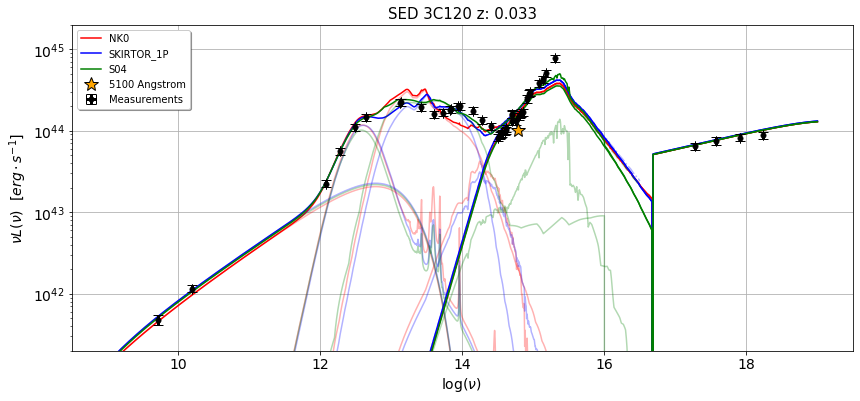

In [26]:
blending('3C120', 5100, 10**(44.01), 2*1e41, 2*1e45, 'Lnu', 'No')

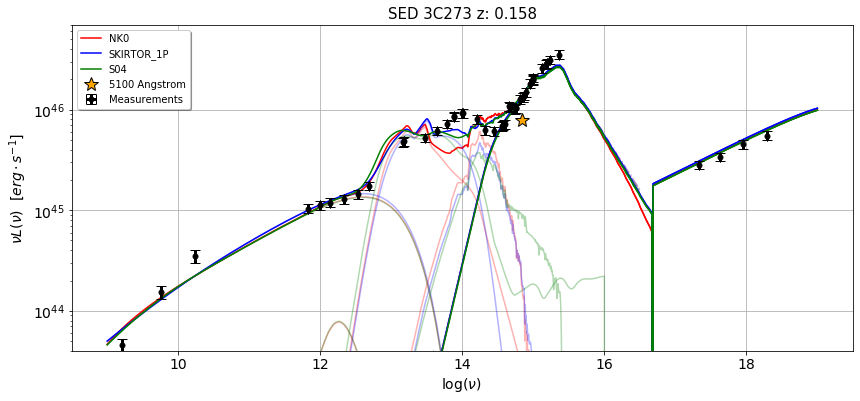

In [27]:
blending('3C273', 5100, 10**(45.90), 4*1e43, 7*1e46, 'Lnu', 'No')

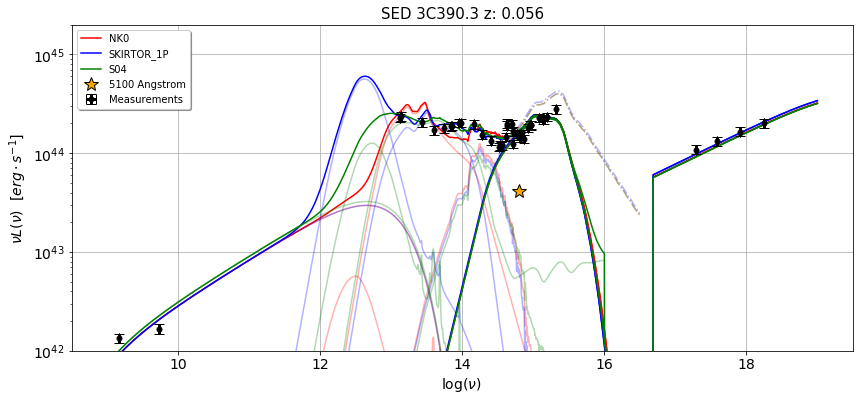

In [8]:
blending('3C390.3', 5100, 10**(43.62), 1*1e42, 2*1e45, 'Lnu', 'No')

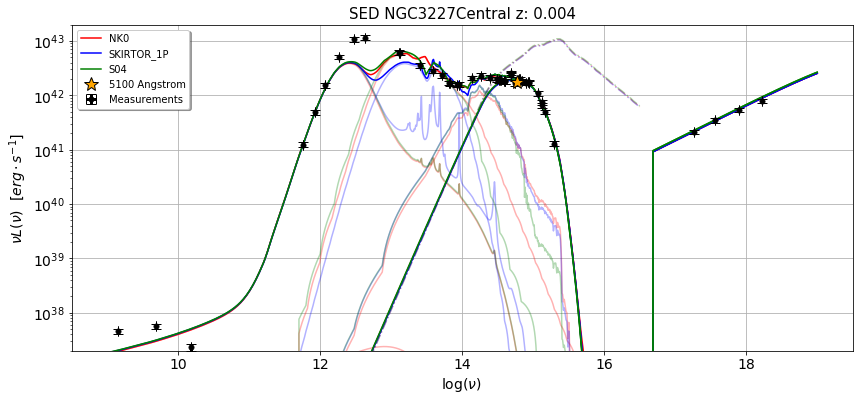

In [9]:
blending('NGC3227Central', 5100, 10**(42.24), 2*1e37, 2*1e43, 'Lnu', 'No')

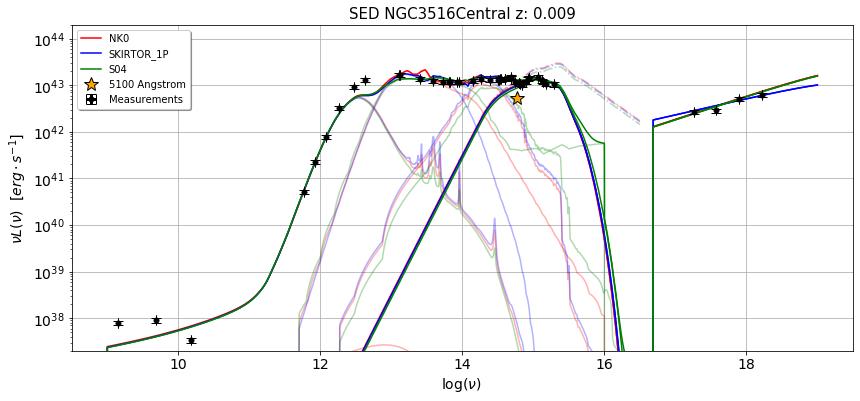

In [10]:
blending('NGC3516Central', 5100, 10**(42.73), 2*1e37, 2*1e44, 'Lnu', 'No')

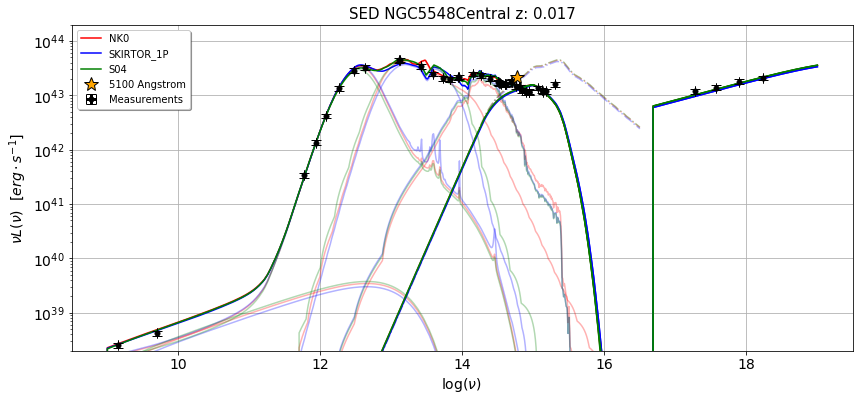

In [11]:
blending('NGC5548Central', 5100, 10**(43.33), 2*1e38, 2*1e44, 'Lnu', 'No')

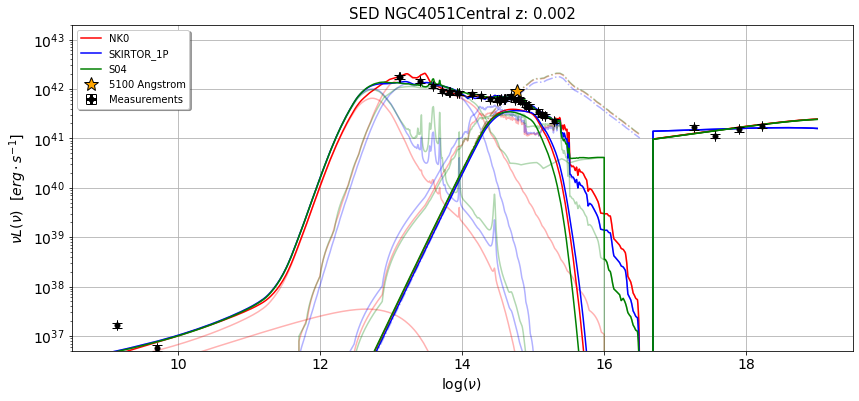

In [12]:
blending('NGC4051Central', 5100, 10**(41.96), 5*1e36, 2*1e43, 'Lnu', 'No')

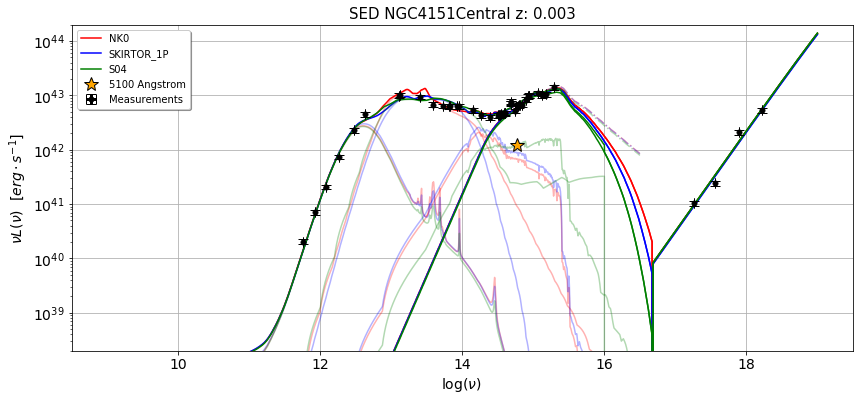

In [13]:
blending('NGC4151Central', 5100, 10**(42.09), 2*1e38, 2*1e44, 'Lnu', 'No')

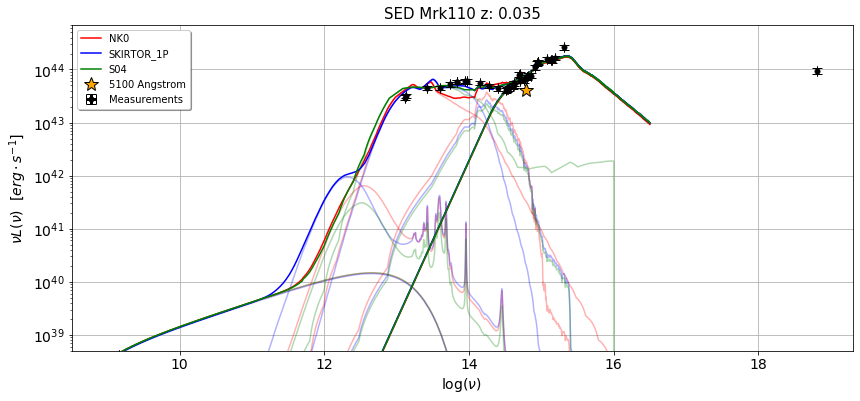

In [14]:
blending('Mrk110', 5100, 10**(43.62), 5*1e38, 7*1e44, 'Lnu', 'No')

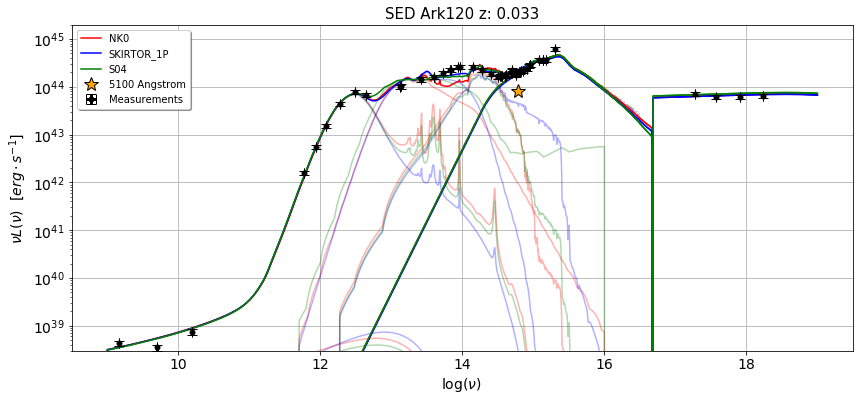

In [15]:
blending('Ark120', 5100, 10**(43.92), 3*1e38, 2*1e45, 'Lnu', 'No')

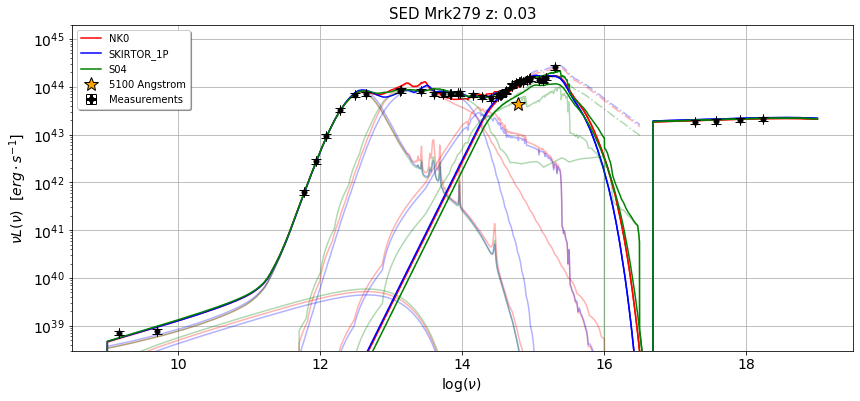

In [16]:
blending('Mrk279', 5100, 10**(43.64), 3*1e38, 2*1e45, 'Lnu', 'No')

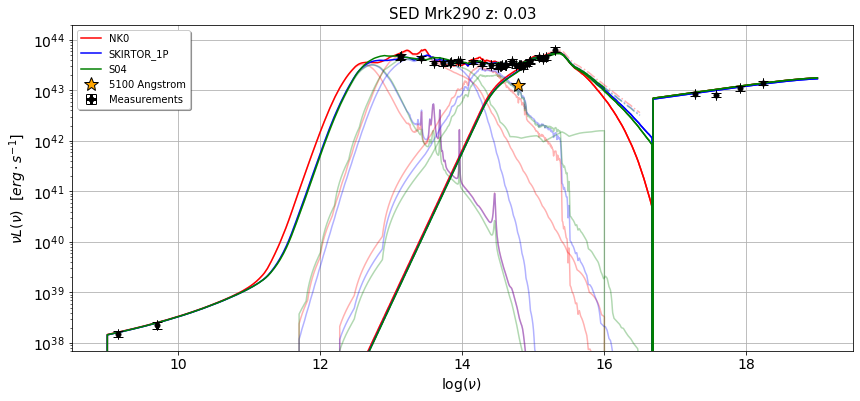

In [17]:
blending('Mrk290', 5100, 10**(43.11), 7*1e37, 2*1e44, 'Lnu', 'No')

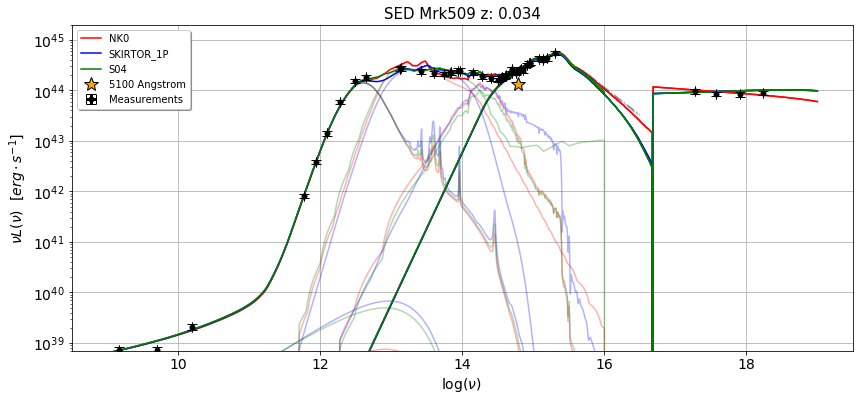

In [18]:
blending('Mrk509', 5100, 10**(44.13), 7*1e38, 2*1e45, 'Lnu', 'No')

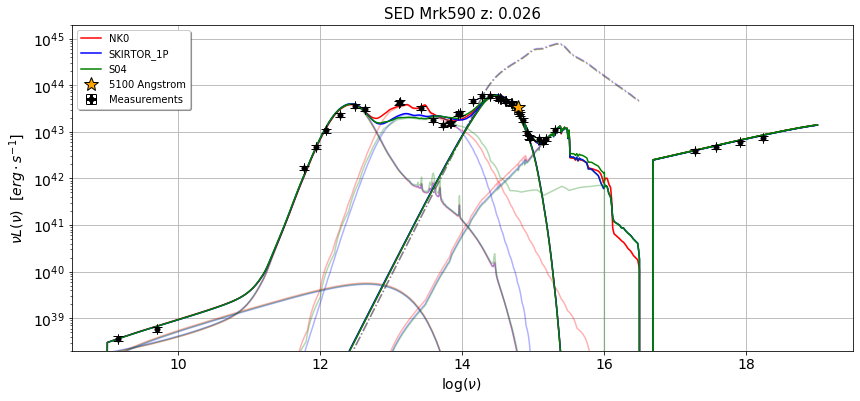

In [19]:
blending('Mrk590', 5100, 10**(43.53), 2*1e38, 2*1e45, 'Lnu', 'No')

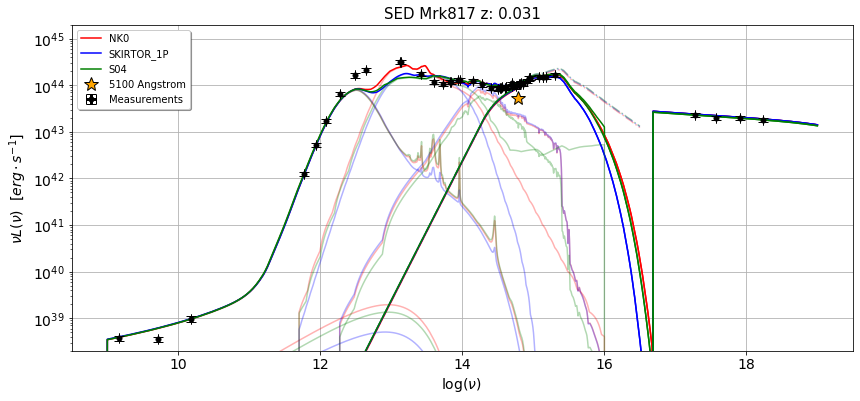

In [20]:
blending('Mrk817', 5100, 10**(43.73), 2*1e38, 2*1e45, 'Lnu', 'No')

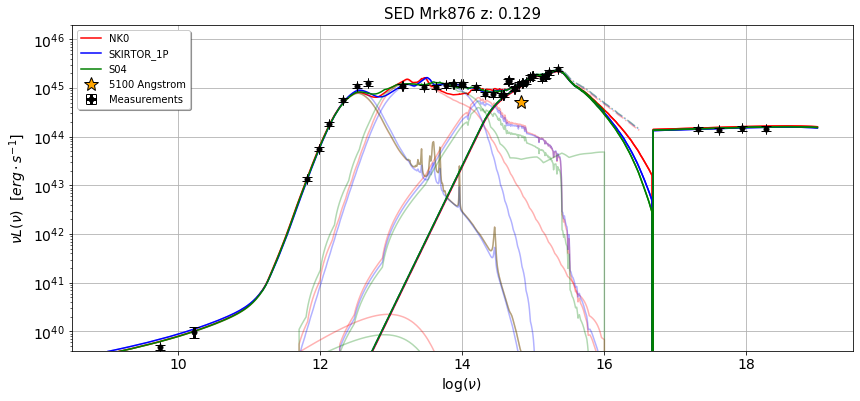

In [21]:
blending('Mrk876', 5100, 10**(44.71), 4*1e39, 2*1e46, 'Lnu', 'No')

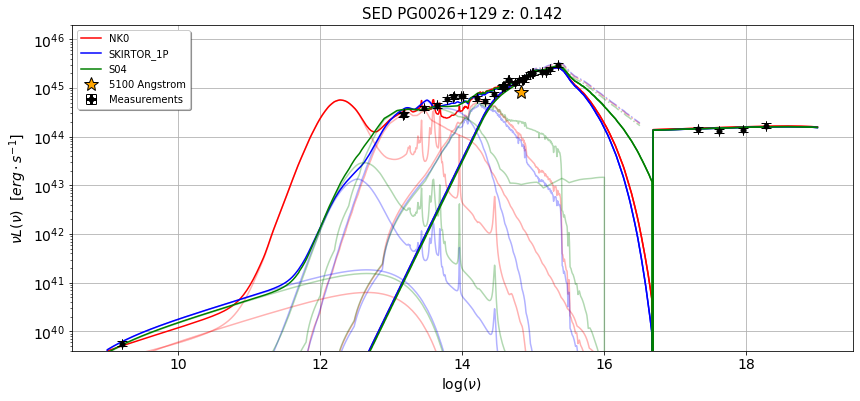

In [22]:
blending('PG0026+129', 5100, 10**(44.91), 4*1e39, 2*1e46, 'Lnu', 'No')

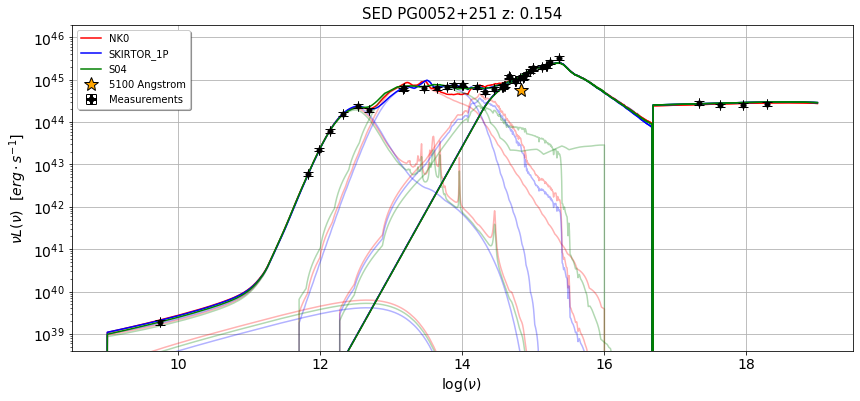

In [23]:
blending('PG0052+251', 5100, 10**(44.75), 4*1e38, 2*1e46, 'Lnu', 'No')

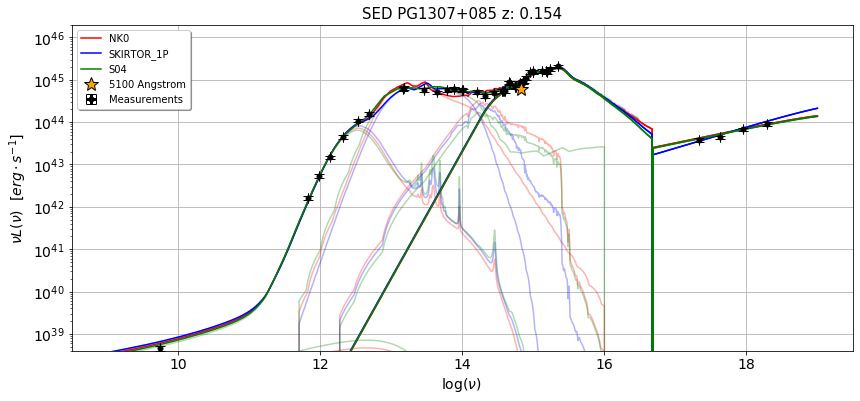

In [24]:
blending('PG1307+085', 5100, 10**(44.79), 4*1e38, 2*1e46, 'Lnu', 'No')

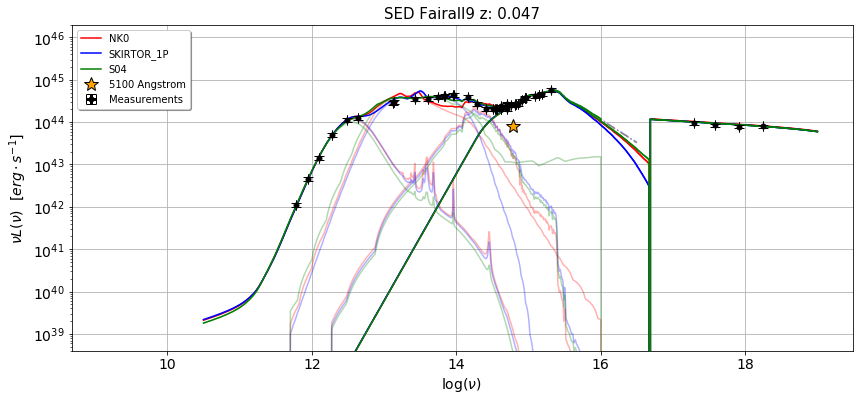

In [25]:
blending('Fairall9', 5100, 10**(43.92), 4*1e38, 2*1e46, 'Lnu', 'No', 'No')